# Performing QSO Classification using Variational Autoencoders¶

This notebook performs Quasar Classification via a simple Autoencoder. The frameworks used for this deep learning model are TensorFlow and Pytorch.


## Authors

* Ash Karale
    

## Contents:

* [Introduction](#one)
* [Importing Modules](#two)
* [Data Acquisition](#three)
* [Data Processing](#four)
* [TensorFlow](#five)
* [PyTorch](#six)
* [TensorFlow vs PyTorch](#seven)


## Versions:

Initial Version: November 2022 (Ash Karale)

Updated Version: April 2023 (Ash Karale)



## Introduction <a class="anchor" id="one"></a>

### Plan is to explain the dataset first, and what we aim to do with it. Next, an introduction to autoencoders and why we chose it. Lastly, an introduction to TensorFlow and PyTorch- I am thinking just a brief paragraph or two as I will write more about them in their cell blocks below

TensorFlow and PyTorch are two of the most popular deep learning frameworks. They allow developers to build and train machine learning models using a variety of techniques, including convolutional neural networks (CNNs), recurrent neural networks (RNNs), and generative adversarial networks (GANs).

## Importing Modules <a class="anchor" id="two"></a>

It is widely recommended to include the import statements for all the necessary modules at the beginning of a Jupyter Notebook or any Python program. 
This practice ensures that the required dependencies are properly imported and accessible at the required points in the code, thus avoiding any potential issues or errors related to missing modules or dependencies.

In [3]:
# Importing all required modules

# System modules allow Python programs to interact with the operating system and perform tasks 
# such as reading and writing files, managing processes, and accessing environment variables 
import os
import sys
import importlib
import pickle
import argparse
import itertools
import csv
from tqdm import tqdm
import time

# Data manipulation modules allow users to perform various operations on data,
# such as cleaning, transforming, aggregating, filtering, and visualizing data
import math
import numpy as np
import pandas as pd

# Visualization modules allow users to create visual representations of data
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
# pd.set_option('display.max_columns', 1000)

# Scikit-learn provides a range of supervised and unsupervised learning algorithms,
# as well as tools for model selection and data preprocessing
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, normalized_mutual_info_score, adjusted_rand_score

# Scipy is a Python library for scientific computing and technical computing
from scipy import stats
from scipy.optimize import linear_sum_assignment as linear_assignment

# Astropy is a Python library for astronomy and astrophysics
from astropy.io import fits
from astropy.table import Table

# TensorFlow is an open-source machine learning library that provides an extensive set of tools and libraries
# for building,training, and deploying neural networks, as well as other machine learning algorithms
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# PyTorch is an open-source machine learning library for Python that provides a range of tools
# and functions for building and training neural networks and other machine learning models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable

print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]


## Data Acquisition <a class="anchor" id="three"></a>

Data acquisition involves the collection and aggregation of data from diverse sources. This crucial initial stage in the data analysis pipeline entails recognizing data sources and acquiring the data in a format suitable for further analysis.

The provided statement establishes the data pathway. If an alternative data source is required, the line in the subsequent cell should be substituted accordingly.

In [4]:
# Defining a variable named 'data_dir' and assigning it the string value /Users/ash/Research/Data/DELVE/ 
# This is the path to the directory where the dataset is stored on the local machine
data_dir = '/Users/ash/Research/Data/DELVE/'

# Using the display() function to display the value of the 'data_dir' variable in the output of the Jupyter Notebook
display(data_dir)

'/Users/ash/Research/Data/DELVE/'

Data file reading is performed using Astropy's Table module due to its versatility and efficiency in handling tabular data. 
Astropy's Table offers a robust solution for manipulating and analyzing various file formats, including CSV, FITS, and more. This choice is driven by the comprehensive functionality and adaptability provided by Astropy's Table, making it an ideal tool for working with tabular data.

In [5]:
from astropy.table import Table

# Reading a data file stored in the FITS format using the Table.read() method 
# The path to the data file is constructed using the os.path.join() method to join the data_dir variable, 
# which specifies the directory containing the data file, and the filename 'fullcat15_30.fits'
data = Table.read(os.path.join(data_dir, 'fullcat15_30.fits'))

# Converting the FITS formatted data to a Pandas DataFrame using the to_pandas() method
# of the Table object for easier pandas manipulation
fcDF_15_30 = data.to_pandas()

#### Data types

The measurements can be classified into several key categories:
- __Astrometry__ includes measurements of celestial coordinates such as right ascension (RA), declination (Dec), proper motion, and parallax.
- __Photometry__ encompasses both point and extended source photometry, providing measurements in terms of AB magnitudes and fluxes (expressed in nJy).
- __Color__ is determined by computing the ratios of fluxes in different wavelength bands.
- __Morphology__ is indicated by a binary value, with 1 representing extended sources and 0 representing point-like sources.
- __Light Curve Features__ are extracted from the SDSS light curves when a match is found.
- __Redshift__ is provided whenever available, including both spectroscopic and photometric measurements.

Inspecting the attributes

In [6]:
# Create a  list of feature column names for the dataset
# These features include photometric magnitudes, extended class, proper motion, and radial velocity
fc_list = [
    'mag_auto_g', 'mag_auto_i', 'mag_auto_r', 'mag_auto_z', 
    # Magnitudes in g, i, r, and z bandsfrom AUTO photometry
    'ypetromag', 'jpetromag', 'hpetromag', 'kspetromag',
    # Magnitudes in Y, J, H, and Ks bands from Petrosian photometry
    'w1mpro', 'w2mpro',
    # Magnitudes in WISE 1 and WISE 2 bands
    'extended_class_g', 'extended_class_r', 'extended_class_i', 'extended_class_z', 
    # Extended class in g, r, i, and z bands
    'pm', 'pmdec', 'pmra', 
    # Total proper motion, proper motion in declination, and proper motion in right ascension
    'radial_velocity',  
    # Radial velocity of the objects
    'classprob_dsc_combmod_star','classprob_dsc_combmod_galaxy','classprob_dsc_combmod_quasar', 
    # Classification of the objects (e.g., star, galaxy, QSO)
]

# Selecting a subset of columns from the DataFrame 'fcDF_15_30' based on the list 'fc_list'
fcDF_15_30 = fcDF_15_30[fc_list]

Data visualization involves the process of representing data in a visual or graphical format.

In [7]:
# Display descriptive statistics to describe and explore data

# The describe() method provides summary statistics for each column of the DataFrame, 
# giving insight into the distribution and spread of the data 
fcDF_15_30.describe()

,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,ypetromag,jpetromag,hpetromag,kspetromag,w1mpro,w2mpro,...,extended_class_r,extended_class_i,extended_class_z,pm,pmdec,pmra,radial_velocity,classprob_dsc_combmod_star,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar
count,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,1.312523e+06,7.681616e+06,2.162878e+06,6.286130e+06,8.226904e+06,8.226904e+06,...,8.226904e+06,8.226904e+06,8.226904e+06,1.557373e+06,1.557373e+06,1.557373e+06,48494.000000,1.854957e+06,1.854957e+06,1.854957e+06
mean,3.621252e+01,2.265878e+01,2.480181e+01,2.248277e+01,1.857671e+01,1.867103e+01,1.783285e+01,1.714291e+01,1.680659e+01,1.663629e+01,...,1.607298e+00,1.857492e+00,1.831789e+00,1.386721e+01,-3.923559e+00,8.006602e+00,15.065438,9.447181e-01,3.015133e-02,2.166022e-02
std,3.001855e+01,1.282219e+01,1.652845e+01,1.344820e+01,1.565382e+00,1.523811e+00,1.433349e+00,1.274097e+00,1.079368e+00,1.070547e+00,...,2.654142e+00,2.206325e+00,2.266141e+00,1.607001e+01,1.240325e+01,1.473784e+01,42.134888,2.224325e-01,1.683584e-01,1.381415e-01
min,1.278190e+01,1.167814e+01,1.210906e+01,1.139630e+01,1.037403e+01,9.689001e+00,8.260656e+00,8.256360e+00,7.068000e+00,6.085000e+00,...,-9.000000e+00,-9.000000e+00,-9.000000e+00,2.600000e-03,-8.026215e+02,-3.656444e+02,-389.880100,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.137134e+01,1.974994e+01,2.029234e+01,1.943825e+01,1.778231e+01,1.793413e+01,1.716681e+01,1.654000e+01,1.628600e+01,1.608700e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,5.070828e+00,-7.266419e+00,8.808007e-01,-5.499497,9.995270e-01,0.000000e+00,0.000000e+00
50%,2.271964e+01,2.084213e+01,2.150048e+01,2.049579e+01,1.887614e+01,1.897750e+01,1.812667e+01,1.739955e+01,1.693600e+01,1.674200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,9.908950e+00,-1.996961e+00,5.454478e+00,12.312459,9.999640e-01,0.000000e+00,0.000000e+00
75%,2.406641e+01,2.170479e+01,2.257661e+01,2.128124e+01,1.971436e+01,1.974666e+01,1.882400e+01,1.802353e+01,1.753000e+01,1.738200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,1.731142e+01,9.636427e-01,1.218151e+01,31.317938,9.999900e-01,0.000000e+00,0.000000e+00
max,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,2.868277e+01,3.056738e+01,2.972356e+01,3.215351e+01,2.004100e+01,1.889200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,8.026368e+02,5.512816e+02,6.766674e+02,761.085100,1.000000e+00,1.000000e+00,1.000000e+00


## Data Processing <a class="anchor" id="four"></a>

Data processing involves converting unprocessed data into a format that is appropriate for analysis. This encompasses several stages, such as data cleansing, data integration, data transformation, data reduction, and data visualization, with the objective of making the data more usable and insightful.

Form a subset containing the maximum possible number of objects that possess significant data values. 
* More specifically, combine the attributes related to Stars, Galaxies, and Quasars.

In [8]:
# Converting the list 'fc15_30' to a Pandas DataFrame using the pd.DataFrame() method
fcDF_15_30 = pd.DataFrame(fcDF_15_30)

# Replacing the string values of the columns named 'classprob_dsc_combmod_star', 'classprob_dsc_combmod_galaxy',
# and 'classprob_dsc_combmod_quasar' with numerical values 0, 1, and 2, respectively.
fcDF_15_30 = fcDF_15_30.replace({'classprob_dsc_combmod_star': 0,
                           'classprob_dsc_combmod_galaxy': 1,
                           'classprob_dsc_combmod_quasar': 2})

# Define a function to determine the class based on the highest class probability
# The function called 'assign_class' that takes a row as input, and based on the 
# class probabilities for each object, assigns the object to one of the classes
def assign_class(row):
    star_prob = row['classprob_dsc_combmod_star']
    galaxy_prob = row['classprob_dsc_combmod_galaxy']
    quasar_prob = row['classprob_dsc_combmod_quasar']
    
    if star_prob > galaxy_prob and star_prob > quasar_prob:
        return 0
    elif galaxy_prob > quasar_prob:
        return 1
    else:
        return 2

# Merging the class probability attributes of galaxies, quasars, and stars into a single 'class' attribute 
# based on the highest probability value
# The apply() method applies the function 'assign_class' to each row of the DataFrame
fcDF_15_30['class'] = fcDF_15_30[['classprob_dsc_combmod_galaxy', 'classprob_dsc_combmod_quasar',
                            'classprob_dsc_combmod_star']].apply(assign_class, axis=1)


In [9]:
# Standardizing and Scaling

# Set X to the entire DataFrame
X = fcDF_15_30
# Remove the 'class' column from X as it is the target variable
X = X.drop(['class'], axis=1)

# Set y to the 'class' column of the DataFrame
y = fcDF_15_30['class']

# Display the shapes and summary statistics 
display(X.shape, y.shape)
display(X.describe())

(8226904, 21)

(8226904,)

,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,ypetromag,jpetromag,hpetromag,kspetromag,w1mpro,w2mpro,...,extended_class_r,extended_class_i,extended_class_z,pm,pmdec,pmra,radial_velocity,classprob_dsc_combmod_star,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar
count,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,1.312523e+06,7.681616e+06,2.162878e+06,6.286130e+06,8.226904e+06,8.226904e+06,...,8.226904e+06,8.226904e+06,8.226904e+06,1.557373e+06,1.557373e+06,1.557373e+06,48494.000000,1.854957e+06,1.854957e+06,1.854957e+06
mean,3.621252e+01,2.265878e+01,2.480181e+01,2.248277e+01,1.857671e+01,1.867103e+01,1.783285e+01,1.714291e+01,1.680659e+01,1.663629e+01,...,1.607298e+00,1.857492e+00,1.831789e+00,1.386721e+01,-3.923559e+00,8.006602e+00,15.065438,9.447181e-01,3.015133e-02,2.166022e-02
std,3.001855e+01,1.282219e+01,1.652845e+01,1.344820e+01,1.565382e+00,1.523811e+00,1.433349e+00,1.274097e+00,1.079368e+00,1.070547e+00,...,2.654142e+00,2.206325e+00,2.266141e+00,1.607001e+01,1.240325e+01,1.473784e+01,42.134888,2.224325e-01,1.683584e-01,1.381415e-01
min,1.278190e+01,1.167814e+01,1.210906e+01,1.139630e+01,1.037403e+01,9.689001e+00,8.260656e+00,8.256360e+00,7.068000e+00,6.085000e+00,...,-9.000000e+00,-9.000000e+00,-9.000000e+00,2.600000e-03,-8.026215e+02,-3.656444e+02,-389.880100,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.137134e+01,1.974994e+01,2.029234e+01,1.943825e+01,1.778231e+01,1.793413e+01,1.716681e+01,1.654000e+01,1.628600e+01,1.608700e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,5.070828e+00,-7.266419e+00,8.808007e-01,-5.499497,9.995270e-01,0.000000e+00,0.000000e+00
50%,2.271964e+01,2.084213e+01,2.150048e+01,2.049579e+01,1.887614e+01,1.897750e+01,1.812667e+01,1.739955e+01,1.693600e+01,1.674200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,9.908950e+00,-1.996961e+00,5.454478e+00,12.312459,9.999640e-01,0.000000e+00,0.000000e+00
75%,2.406641e+01,2.170479e+01,2.257661e+01,2.128124e+01,1.971436e+01,1.974666e+01,1.882400e+01,1.802353e+01,1.753000e+01,1.738200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,1.731142e+01,9.636427e-01,1.218151e+01,31.317938,9.999900e-01,0.000000e+00,0.000000e+00
max,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,2.868277e+01,3.056738e+01,2.972356e+01,3.215351e+01,2.004100e+01,1.889200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,8.026368e+02,5.512816e+02,6.766674e+02,761.085100,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
# Split the dataset into training and testing sets (50% training, 50% testing)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 1, shuffle=True)

# Impute missing values by using the mean or median value
X_train = X_train.fillna(X_train.mean()) # or X_train.median()
X_test = X_test.fillna(X_test.mean()) # or X_test.median()

# Create a StandardScaler object to standardize the features
scaler = preprocessing.StandardScaler()
# Fit the scaler using the training data
scaler.fit(X_train)
# Transform the training data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
# Transform the testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the scaled training and testing data
display(X_train_scaled.shape, X_test_scaled.shape)

(4113452, 21)

(4113452, 21)

In [11]:
# Display the summary statistics of the training data
display(X_train.describe())

# Display the summary statistics of the testing data
display(X_test.describe())

,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,ypetromag,jpetromag,hpetromag,kspetromag,w1mpro,w2mpro,...,extended_class_r,extended_class_i,extended_class_z,pm,pmdec,pmra,radial_velocity,classprob_dsc_combmod_star,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar
count,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,...,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06
mean,3.622024e+01,2.265907e+01,2.480370e+01,2.248994e+01,1.857653e+01,1.867119e+01,1.783308e+01,1.714314e+01,1.680671e+01,1.663623e+01,...,1.606736e+00,1.857049e+00,1.830402e+00,1.386853e+01,-3.923129e+00,7.989458e+00,1.496564e+01,9.447756e-01,2.995606e-02,2.181235e-02
std,3.002534e+01,1.282308e+01,1.653305e+01,1.346784e+01,6.256626e-01,1.472865e+00,7.345629e-01,1.113901e+00,1.079560e+00,1.070733e+00,...,2.654679e+00,2.206470e+00,2.268565e+00,7.004411e+00,5.450415e+00,6.387013e+00,3.187139e+00,1.055817e-01,7.970007e-02,6.582942e-02
min,1.278190e+01,1.167814e+01,1.210906e+01,1.139630e+01,1.051031e+01,9.689001e+00,9.826766e+00,9.507744e+00,7.965000e+00,7.808000e+00,...,-9.000000e+00,-9.000000e+00,-9.000000e+00,2.600000e-03,-8.026215e+02,-3.656444e+02,-2.607022e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.137033e+01,1.975028e+01,2.029223e+01,1.943848e+01,1.857653e+01,1.803132e+01,1.783308e+01,1.686470e+01,1.628600e+01,1.608700e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,1.386853e+01,-3.923129e+00,7.989458e+00,1.496564e+01,9.447756e-01,2.995606e-02,2.181235e-02
50%,2.271930e+01,2.084202e+01,2.149993e+01,2.049579e+01,1.857653e+01,1.885876e+01,1.783308e+01,1.714314e+01,1.693600e+01,1.674200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,1.386853e+01,-3.923129e+00,7.989458e+00,1.496564e+01,9.447756e-01,2.995606e-02,2.181235e-02
75%,2.406738e+01,2.170480e+01,2.257708e+01,2.128109e+01,1.857653e+01,1.969211e+01,1.783308e+01,1.783367e+01,1.753100e+01,1.738300e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,1.386853e+01,-3.923129e+00,7.989458e+00,1.496564e+01,9.447756e-01,2.995606e-02,2.181235e-02
max,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,2.868277e+01,3.056738e+01,2.623996e+01,3.215351e+01,2.003600e+01,1.889200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,8.026368e+02,5.512816e+02,6.766674e+02,4.176311e+02,1.000000e+00,1.000000e+00,1.000000e+00


,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,ypetromag,jpetromag,hpetromag,kspetromag,w1mpro,w2mpro,...,extended_class_r,extended_class_i,extended_class_z,pm,pmdec,pmra,radial_velocity,classprob_dsc_combmod_star,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar
count,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,...,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06,4.113452e+06
mean,3.620479e+01,2.265848e+01,2.479992e+01,2.247560e+01,1.857690e+01,1.867087e+01,1.783262e+01,1.714267e+01,1.680647e+01,1.663633e+01,...,1.607860e+00,1.857935e+00,1.833176e+00,1.386589e+01,-3.923989e+00,8.023788e+00,1.516541e+01,9.446607e-01,3.034684e-02,2.150791e-02
std,3.001175e+01,1.282129e+01,1.652386e+01,1.342852e+01,6.248419e-01,1.472027e+00,7.353093e-01,1.113538e+00,1.079176e+00,1.070361e+00,...,2.653605e+00,2.206180e+00,2.263713e+00,6.979330e+00,5.342078e+00,6.437422e+00,3.281982e+00,1.056586e-01,8.018615e-02,6.536032e-02
min,1.316891e+01,1.246892e+01,1.211705e+01,1.221446e+01,1.037403e+01,1.013221e+01,8.260656e+00,8.256360e+00,7.068000e+00,6.085000e+00,...,-9.000000e+00,-9.000000e+00,-9.000000e+00,5.783000e-03,-7.481313e+02,-3.379641e+02,-3.898801e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.137233e+01,1.974964e+01,2.029244e+01,1.943801e+01,1.857690e+01,1.803143e+01,1.783262e+01,1.686352e+01,1.628600e+01,1.608700e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,1.386589e+01,-3.923989e+00,8.023788e+00,1.516541e+01,9.446607e-01,3.034684e-02,2.150791e-02
50%,2.272001e+01,2.084224e+01,2.150103e+01,2.049578e+01,1.857690e+01,1.885797e+01,1.783262e+01,1.714267e+01,1.693600e+01,1.674200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,1.386589e+01,-3.923989e+00,8.023788e+00,1.516541e+01,9.446607e-01,3.034684e-02,2.150791e-02
75%,2.406546e+01,2.170478e+01,2.257610e+01,2.128138e+01,1.857690e+01,1.969202e+01,1.783262e+01,1.783368e+01,1.753000e+01,1.738200e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,1.386589e+01,-3.923989e+00,8.023788e+00,1.516541e+01,9.446607e-01,3.034684e-02,2.150791e-02
max,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,2.677974e+01,2.986823e+01,2.972356e+01,2.691011e+01,2.004100e+01,1.886600e+01,...,3.000000e+00,3.000000e+00,3.000000e+00,7.995270e+02,5.512816e+02,6.727384e+02,7.610851e+02,1.000000e+00,1.000000e+00,1.000000e+00


## TensorFlow <a class="anchor" id="five"></a>

Google created TensorFlow and made it available in 2015. This highly scalable framework is extensively utilized for machine learning applications at the production level.

TensorFlow operates on a data flow graph, where mathematical operations are represented by nodes and data inputs and outputs are represented by edges. By adopting this approach, TensorFlow can optimize computations and execute them efficiently on both CPUs and GPUs.

### Model Definition

The term "model architecture" encompasses the holistic arrangement and composition of a machine learning model. This encompasses factors such as the quantity and nature of layers, the number of neurons or units within each layer, the activation functions employed in each layer, the training optimization algorithm, and other design considerations entailed in the model's creation.

An autoencoder is a neural network that is utilized for unsupervised learning purposes. 

TensorFlow offers the Keras API for defining an autoencoder model. This model comprises an encoder and a decoder network, which are trained to reconstruct the input data. The model parameters can be optimized through backpropagation and gradient descent algorithms. Once trained, the model finds applications in tasks such as dimensionality reduction, anomaly detection, and data generation.

In [12]:
'TF Tester 4'
# Define the simple autoencoder function
def Autoencoder_Simple(input_size):
    # Calculate the hidden layer size (half of the input size)
    hidden_size = int(input_size / 2.0)
    # Calculate the bottleneck layer size (half of the hidden layer size)
    bottleneck_size = int(hidden_size / 2.0)
    # Define the input layer with the specified input size
    input_tab = Input(shape=(input_size,))
    # Define the first hidden layer with 'relu' activation function
    hidden_1 = layers.Dense(hidden_size, activation='relu')(input_tab)
    # Define the bottleneck layer with 'relu' activation function
    bottleneck = layers.Dense(bottleneck_size, activation='relu')(hidden_1)
    # Define the second hidden layer with 'relu' activation function
    hidden_2 = layers.Dense(hidden_size, activation='relu')(bottleneck)
    # Define the output layer with 'linear' activation function
    output_tab = layers.Dense(input_size, activation='linear')(hidden_2)
    # Create the encoder model, which includes the input layer and bottleneck layer
    encoder = Model(input_tab, bottleneck)
    # Create the full autoencoder model, which includes the input and output layers
    model = Model(input_tab, output_tab)

    # Return both the full autoencoder model and the encoder model
    return model 'decoder', encoder

In [13]:
'TF Tester 4'
from tensorflow.keras import layers
# Set the input size based on the number of features in the dataset
input_size = X.shape[1]
# Call the Autoencoder_Simple function, passing the input_size as an argument
model, encoder = Autoencoder_Simple(input_size)

2023-05-13 18:43:48.939706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-13 18:43:48.940149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


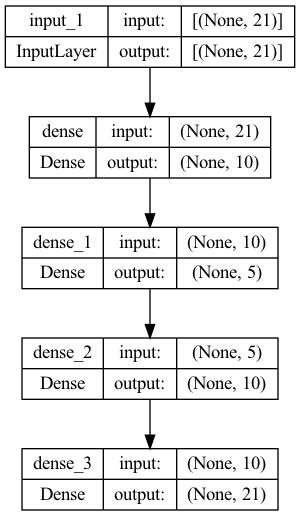

In [14]:
'TF Tester 4'

# Plot the model architecture
plot_model(model, show_shapes=True, to_file='model.png')

### Model Training

Model training involves the procedure of instructing a machine learning model to generate precise predictions for novel data. Within unsupervised learning, model training pertains to comprehending the inherent patterns within the data without relying on explicit labels.

The process of training an autoencoder model in TensorFlow revolves around optimizing its parameters to minimize the disparity between the input and output data. This optimization is achieved by reducing the reconstruction error utilizing an optimization algorithm like stochastic gradient descent. 

Typically, a substantial dataset is employed to train the model, aiming to acquire meaningful data representations beneficial for tasks such as data compression, denoising, and anomaly detection. During training, the weights and biases of the neural network are iteratively adjusted through backpropagation, wherein the gradients of the loss function with respect to the model parameters are computed.

In [ ]:
'TF Tester 4'
from tensorflow.keras.optimizers import Adam
# Set the number of epochs
n_epochs = 50

# Compile the model with Adam optimizer and mean squared error loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model using the scaled training data and validation data
history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=n_epochs, batch_size=16, verbose=2,
                    validation_data=(X_test_scaled, X_test_scaled))

Epoch 1/50


2023-05-13 18:44:03.650187: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-13 18:44:03.903588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-13 19:02:39.378503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


257091/257091 - 1771s - loss: 0.2014 - val_loss: 0.1973 - 1771s/epoch - 7ms/step
Epoch 2/50
257091/257091 - 1734s - loss: 0.1946 - val_loss: 0.1970 - 1734s/epoch - 7ms/step
Epoch 3/50
257091/257091 - 1846s - loss: 0.1941 - val_loss: 0.1959 - 1846s/epoch - 7ms/step
Epoch 4/50
257091/257091 - 1742s - loss: 0.1935 - val_loss: 0.1955 - 1742s/epoch - 7ms/step
Epoch 5/50
257091/257091 - 1762s - loss: 0.1934 - val_loss: 0.1951 - 1762s/epoch - 7ms/step
Epoch 6/50
257091/257091 - 1776s - loss: 0.1934 - val_loss: 0.1950 - 1776s/epoch - 7ms/step
Epoch 7/50
257091/257091 - 5554s - loss: 0.1934 - val_loss: 0.1950 - 5554s/epoch - 22ms/step
Epoch 8/50
257091/257091 - 43917s - loss: 0.1933 - val_loss: 0.1946 - 43917s/epoch - 171ms/step
Epoch 9/50
257091/257091 - 1794s - loss: 0.1933 - val_loss: 0.1948 - 1794s/epoch - 7ms/step
Epoch 10/50
257091/257091 - 1905s - loss: 0.1933 - val_loss: 0.1956 - 1905s/epoch - 7ms/step
Epoch 11/50
257091/257091 - 1771s - loss: 0.1933 - val_loss: 0.1953 - 1771s/epoch - 7

### Model Evaluation

Model evaluation involves assessing the predictive capability of a machine learning model by testing it on a separate dataset, distinct from the training data. This assessment aims to gauge the model's performance and effectiveness.

In the case of an autoencoder, evaluating the model focuses on determining its ability to accurately reconstruct unseen input data. This evaluation involves comparing the original input data with the output data generated by the autoencoder and quantifying the dissimilarity between them.

A common approach for model evaluation is to plot the loss function's trajectory throughout the training process. The loss function measures the disparity between the model's predictions and the actual data, and the objective during training is to minimize this discrepancy. By visualizing the loss function over time, we gain insights into the model's learning progress.

In [ ]:
'TF Tester 1'
# Plot the training and testing loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## PyTorch <a class="anchor" id="six"></a>

Facebook introduced PyTorch in 2017 as a flexible framework that offers ease of use and customization. 

Unlike other frameworks, PyTorch utilizes a dynamic computational graph, enabling developers to construct models in a Pythonic manner. This feature proves particularly advantageous when creating dynamic models that involve varying input shapes or sizes.

### Model Definition

The term "model architecture" encompasses the holistic arrangement and composition of a machine learning model. This encompasses factors such as the quantity and nature of layers, the number of neurons or units within each layer, the activation functions employed in each layer, the training optimization algorithm, and other design considerations entailed in the model's creation.

An autoencoder is a neural network that is utilized for unsupervised learning purposes.

When working with PyTorch, the process of creating an autoencoder model entails constructing an encoder and decoder network. These components are trained jointly to acquire a condensed representation of the input data. 
The encoder network is responsible for receiving the input and generating a representation with reduced dimensions. Subsequently, the decoder network utilizes this representation to produce the reconstructed output. 
The primary objective is to minimize the disparity between the input and output, while simultaneously reducing the dimensionality of the representation.

In [29]:
'PT Tester 1'
# Define the Autoencoder model
# Define a class named Autoencoder that inherits from the PyTorch nn.Module class
class Autoencoder(nn.Module):
    # Initialize the Autoencoder class, taking an input_size argument
    def __init__(self, input_size):
        # Call the constructor of the parent nn.Module class
        super(Autoencoder, self).__init__()
        # Calculate the size of the hidden layer as half of the input_size
        hidden_size = int(input_size / 2)
        # Calculate the size of the bottleneck layer as half of the hidden_size
        bottleneck_size = int(hidden_size / 2)
        # Define the encoder part of the autoencoder as a sequence of layers
        self.encoder = nn.Sequential(
            # Add a linear layer with input_size as input and hidden_size as output
            nn.Linear(input_size, hidden_size),
            # Add a ReLU activation layer
            nn.ReLU(),
            # Add a linear layer with hidden_size as input and bottleneck_size as output
            nn.Linear(hidden_size, bottleneck_size),
            # Add a ReLU activation layer
            nn.ReLU(),
        )
        # Define the decoder part of the autoencoder as a sequence of layers
        self.decoder = nn.Sequential(
            # Add a linear layer with bottleneck_size as input and hidden_size as output
            nn.Linear(bottleneck_size, hidden_size),
            # Add a ReLU activation layer
            nn.ReLU(),
            # Add a linear layer with hidden_size as input and input_size as output
            nn.Linear(hidden_size, input_size),
        )

    # Define the forward pass of the autoencoder
    def forward(self, x):
        # Pass the input through the encoder to get the bottleneck representation
        x = self.encoder(x)
        # Pass the bottleneck representation through the decoder to get the reconstructed output
        x = self.decoder(x)
        # Return the reconstructed output
        return x

In [30]:
'PT Tester 1 give more explanation to keras'
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)

# Create a PyTorch TensorDataset for the training and testing data
train_dataset = TensorDataset(X_train_torch)  
test_dataset = TensorDataset(X_test_torch)
# Create a DataLoader for the training and testing data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check to ensure that the data does not contain any nan or infinity values
print("X_train_torch contains nan:", torch.isnan(X_train_torch).any())
print("X_train_torch contains inf:", torch.isinf(X_train_torch).any())
print("X_test_torch contains nan:", torch.isnan(X_test_torch).any())
print("X_test_torch contains inf:", torch.isinf(X_test_torch).any())

X_train_torch contains nan: tensor(False)
X_train_torch contains inf: tensor(False)
X_test_torch contains nan: tensor(False)
X_test_torch contains inf: tensor(False)


In [32]:
'PT Tester 1'
# Instantiate the model
# Get the number of features in the input data
input_size = X.shape[1] 
# Create an instance of the Autoencoder class with the input size
model = Autoencoder(input_size)

# Loss and optimizer
import torch.optim as optim
# Define the loss function as mean squared error (MSE) loss
criterion = nn.MSELoss() 
# Create an Adam optimizer with the specified learning rate and the model's parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)  

### Model Training

Model training involves the procedure of instructing a machine learning model to generate precise predictions for novel data. Within unsupervised learning, model training pertains to comprehending the inherent patterns within the data without relying on explicit labels. 

PyTorch's Autoencoder Model Training comprises several steps, including the specification of the model's structure, configuration of hyperparameters, and the actual training process. 
To begin, the encoder and decoder architectures are established using the nn.Module class. Subsequently, important hyperparameters like learning rate, batch size, and number of epochs are defined. 
The optimizer and loss function are then determined.

Following these preparations, the model is trained on the training dataset while also undergoing validation on a separate dataset and testing on yet another dataset. 
Once the training is complete, the trained model can be utilized for making predictions and generating new data.

In [33]:
'PT Tester 1'
# Set the number of epochs for training
n_epochs = 50

# Loop through each epoch
for epoch in range(n_epochs):
    # Initialize the train loss for the current epoch to 0
    train_loss = 0.0
    # Loop through each batch in the train_loader
    for batch in train_loader:
        # Get the input data from the current batch
        inputs = batch[0]      
        # Reset the optimizer gradients to 0
        optimizer.zero_grad()   
        # Pass the inputs through the model to get the outputs
        outputs = model(inputs)     
        # Calculate the loss between the outputs and the original inputs
        loss = criterion(outputs, inputs)      
        # Backpropagate the gradients
        loss.backward()    
        # Update the model parameters using the optimizer
        optimizer.step()     
        # Accumulate the train loss for the current batch
        train_loss += loss.item()
    # Initialize the test loss for the current epoch to 0
    test_loss = 0.0
    
    # Disable gradient calculations for evaluation
    with torch.no_grad():
        # Loop through each batch in the test_loader
        for batch in test_loader:
            # Get the input data from the current batch
            inputs = batch[0]
            # Pass the inputs through the model to get the outputs
            outputs = model(inputs)  
            # Calculate the loss between the outputs and the original inputs
            loss = criterion(outputs, inputs)    
            # Accumulate the test loss for the current batch
            test_loss += loss.item()
    
    # Print the train and test loss for the current epoch
    print(f"Epoch: {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.6f}, Test Loss: {test_loss/len(test_loader):.6f}")

Epoch: 1/50, Train Loss: 0.204974, Test Loss: 0.180165
Epoch: 2/50, Train Loss: 0.176585, Test Loss: 0.175485
Epoch: 3/50, Train Loss: 0.171567, Test Loss: 0.168642
Epoch: 4/50, Train Loss: 0.197860, Test Loss: 0.194732
Epoch: 5/50, Train Loss: 0.191366, Test Loss: 0.185105
Epoch: 6/50, Train Loss: 0.183782, Test Loss: 0.182551
Epoch: 7/50, Train Loss: 0.184195, Test Loss: 0.182726
Epoch: 8/50, Train Loss: 0.184192, Test Loss: 0.182597
Epoch: 9/50, Train Loss: 0.184411, Test Loss: 0.185470
Epoch: 10/50, Train Loss: 0.182817, Test Loss: 0.180296
Epoch: 11/50, Train Loss: 0.183069, Test Loss: 0.182173
Epoch: 12/50, Train Loss: 0.184476, Test Loss: 0.183482
Epoch: 13/50, Train Loss: 0.184548, Test Loss: 0.183062
Epoch: 14/50, Train Loss: 0.184422, Test Loss: 0.181984
Epoch: 15/50, Train Loss: 0.184155, Test Loss: 0.186118
Epoch: 16/50, Train Loss: 0.184086, Test Loss: 0.185751
Epoch: 17/50, Train Loss: 0.184288, Test Loss: 0.183167
Epoch: 18/50, Train Loss: 0.184408, Test Loss: 0.190368
E

### Model Evaluation

Model evaluation involves assessing the predictive capability of a machine learning model by testing it on a separate dataset, distinct from the training data. This assessment aims to gauge the model's performance and effectiveness.

In the case of an autoencoder, evaluating the model focuses on determining its ability to accurately reconstruct unseen input data. This evaluation involves comparing the original input data with the output data generated by the autoencoder and quantifying the dissimilarity between them.

A common approach for model evaluation is to plot the loss function's trajectory throughout the training process. The loss function measures the disparity between the model's predictions and the actual data, and the objective during training is to minimize this discrepancy. By visualizing the loss function over time, we gain insights into the model's learning progress.

In [3]:
'PT Tester 1'

# Using the output as a string and extract the losses from it to plot.

# Output as a string
output = '''
Epoch: 1/50, Train Loss: 0.204974, Test Loss: 0.180165
Epoch: 2/50, Train Loss: 0.176585, Test Loss: 0.175485
Epoch: 3/50, Train Loss: 0.171567, Test Loss: 0.168642
Epoch: 4/50, Train Loss: 0.197860, Test Loss: 0.194732
Epoch: 5/50, Train Loss: 0.191366, Test Loss: 0.185105
Epoch: 6/50, Train Loss: 0.183782, Test Loss: 0.182551
Epoch: 7/50, Train Loss: 0.184195, Test Loss: 0.182726
Epoch: 8/50, Train Loss: 0.184192, Test Loss: 0.182597
Epoch: 9/50, Train Loss: 0.184411, Test Loss: 0.185470
Epoch: 10/50, Train Loss: 0.182817, Test Loss: 0.180296
Epoch: 11/50, Train Loss: 0.183069, Test Loss: 0.182173
Epoch: 12/50, Train Loss: 0.184476, Test Loss: 0.183482
Epoch: 13/50, Train Loss: 0.184548, Test Loss: 0.183062
Epoch: 14/50, Train Loss: 0.184422, Test Loss: 0.181984
Epoch: 15/50, Train Loss: 0.184155, Test Loss: 0.186118
Epoch: 16/50, Train Loss: 0.184086, Test Loss: 0.185751
Epoch: 17/50, Train Loss: 0.184288, Test Loss: 0.183167
Epoch: 18/50, Train Loss: 0.184408, Test Loss: 0.190368
Epoch: 19/50, Train Loss: 0.184166, Test Loss: 0.182013
Epoch: 20/50, Train Loss: 0.184299, Test Loss: 0.182965
Epoch: 21/50, Train Loss: 0.184320, Test Loss: 0.188758
Epoch: 22/50, Train Loss: 0.184405, Test Loss: 0.182461
Epoch: 23/50, Train Loss: 0.184702, Test Loss: 0.183229
Epoch: 24/50, Train Loss: 0.184036, Test Loss: 0.184159
Epoch: 25/50, Train Loss: 0.184053, Test Loss: 0.183055
Epoch: 26/50, Train Loss: 0.184493, Test Loss: 0.182483
Epoch: 27/50, Train Loss: 0.184141, Test Loss: 0.186442
Epoch: 28/50, Train Loss: 0.184628, Test Loss: 0.183238
Epoch: 29/50, Train Loss: 0.184792, Test Loss: 0.182296
Epoch: 30/50, Train Loss: 0.184565, Test Loss: 0.182591
Epoch: 31/50, Train Loss: 0.184569, Test Loss: 0.184549
Epoch: 32/50, Train Loss: 0.184111, Test Loss: 0.182878
Epoch: 33/50, Train Loss: 0.184840, Test Loss: 0.183035
Epoch: 34/50, Train Loss: 0.184522, Test Loss: 0.182288
Epoch: 35/50, Train Loss: 0.184345, Test Loss: 0.182474
Epoch: 36/50, Train Loss: 0.184023, Test Loss: 0.182138
Epoch: 37/50, Train Loss: 0.184334, Test Loss: 0.182417
Epoch: 38/50, Train Loss: 0.184844, Test Loss: 0.181717
Epoch: 39/50, Train Loss: 0.184653, Test Loss: 0.182992
Epoch: 40/50, Train Loss: 0.184247, Test Loss: 0.184875
Epoch: 41/50, Train Loss: 0.184033, Test Loss: 0.182938
Epoch: 42/50, Train Loss: 0.183228, Test Loss: 0.182625
Epoch: 43/50, Train Loss: 0.183353, Test Loss: 0.184283
Epoch: 44/50, Train Loss: 0.183265, Test Loss: 0.182878
Epoch: 45/50, Train Loss: 0.183363, Test Loss: 0.182230
Epoch: 46/50, Train Loss: 0.183643, Test Loss: 0.183758
Epoch: 47/50, Train Loss: 0.183767, Test Loss: 0.182404
Epoch: 48/50, Train Loss: 0.183774, Test Loss: 0.183001
Epoch: 49/50, Train Loss: 0.183544, Test Loss: 0.181167
Epoch: 50/50, Train Loss: 0.183839, Test Loss: 0.183598
'''

# Extract the losses from the output
loss_data = output.strip().split('\n')

# Initialize lists to store the train and test losses
train_losses = []
test_losses = []

# Loop through each line in the loss_data
for line in loss_data:
    # Split the line by commas and extract the losses
    parts = line.split(',')
    train_loss_str = parts[1]
    test_loss_str = parts[2]
    
    train_loss = float(train_loss_str.split(':')[1].strip())
    test_loss = float(test_loss_str.split(':')[1].strip())

    # Append the losses to their respective lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

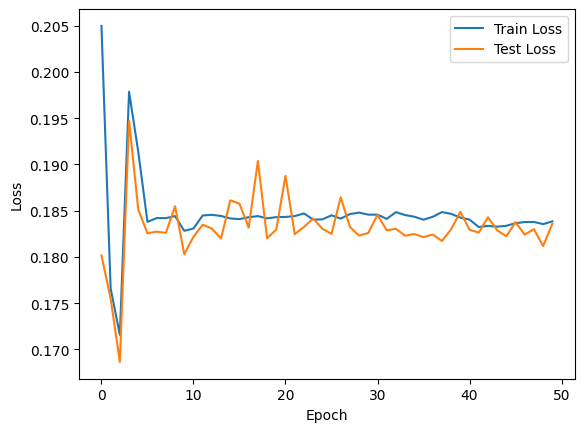

In [5]:
# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Discussion of the Train vs Test Loss Plot

The training loss is slightly decreasing over time which is good.

The test loss is also decreasing, but not consistently. Ideally, it should decrease consistently, similar to the training loss. It doesn't seem to overfit as it isn't increasing.

The training and test losses are quite close to each other which is good as it suggests that the model is not overfitting or underfitting too much.

Although, the output suggests that the model has not trained properly due to the loss not being low enough.
Maybe the training data is insufficient?

## Tensorflow vs PyTorch  <a class="anchor" id="seven"></a>

### Model Definition

#### Similarities

* Both codes define an autoencoder model architecture that consists of an encoder and a decoder, and the size of the layers decreases progressively towards the bottleneck.
* They both start by defining the input size and calculating the sizes of the hidden layer and the bottleneck layer. The sizes are calculated the same way: the hidden layer is half the size of the input layer, and the bottleneck layer is half the size of the hidden layer.
* Both models use the ReLU activation function for the hidden layers.
* Both models use linear transformation for the output layer.

#### Differences

* **Library and Syntax:** The main difference between the two codes is the deep learning library they use. The first code uses TensorFlow with Keras API, which uses a functional API for defining models. The second code uses PyTorch, which uses an object-oriented approach. The way models are defined and the syntax used are different due to these library differences.

* **Layer Definition:** In the TensorFlow code, each layer is explicitly defined one at a time and connected to the previous one. In the PyTorch code, layers are defined inside the nn.Sequential(), which automatically connects the layers in the order they are defined.

* **Model Structure:** In the TensorFlow code, two models are returned: the autoencoder model and the encoder model. The PyTorch code only defines and returns the autoencoder model. If you wanted the encoder model in PyTorch, you'd need to access the .encoder attribute of an instance of the Autoencoder class.

* **Forward Pass:** In the TensorFlow code, the forward pass (how data moves through the network during inference) is implicitly defined by the order in which layers are defined and connected. In PyTorch, the forward pass is explicitly defined in the forward method.

**TensorFlow:**
def Autoencoder_Simple(input_size):  
#This line defines the function Autoencoder_Simple which takes an argument input_size.

**PyTorch:**
class Autoencoder(nn.Module):  
#This line defines a new class Autoencoder which inherits from nn.Module. In PyTorch, all neural networks should inherit from this class.

**TensorFlow:**
hidden_size = int(input_size / 2.0)   
#This line calculates the size of the hidden layer. It is identical in both pieces of code.  

**PyTorch:**
def __init__(self, input_size):
    super(Autoencoder, self).__init__()
    hidden_size = int(input_size / 2)
  
#These lines define the initialization method for the Autoencoder class, which takes an argument input_size. The super() function is used to call the initialization method of the parent nn.Module class. The hidden_size is calculated in the same way as in the TensorFlow code.  

**TensorFlow:**
bottleneck_size = int(hidden_size / 2.0)    
#This line calculates the size of the bottleneck layer. It is identical in both pieces of code.

**PyTorch:**
bottleneck_size = int(hidden_size / 2)    
#This line calculates the size of the bottleneck layer in the same way as in the TensorFlow code.

**TensorFlow:**
input_tab = Input(shape=(input_size,))    
#This line defines the input layer for the TensorFlow model. The size of the input layer is defined by input_size.

**PyTorch:**
self.encoder = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, bottleneck_size),
    nn.ReLU(),
)
  
#This block of code in PyTorch defines the encoder part of the autoencoder. It is a sequence of a linear layer, a ReLU activation, another linear layer, and another ReLU activation. The sizes of the layers and the types of activations correspond to those in the TensorFlow code.

**TensorFlow:**
hidden_1 = layers.Dense(hidden_size, activation='relu')(input_tab)
bottleneck = layers.Dense(bottleneck_size, activation='relu')(hidden_1)
  
#These lines define the first two layers of the autoencoder: a dense layer with size hidden_size and a ReLU activation, and another dense layer with size bottleneck_size and a ReLU activation. These correspond to the first two layers in the PyTorch encoder.

**PyTorch:**
self.decoder = nn.Sequential(
    nn.Linear(bottleneck_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, input_size),
)
  
#This block of code defines the decoder part of the autoencoder in PyTorch. It is a sequence of a linear layer, a ReLU activation, and another linear layer. The sizes of the layers and the types of activations correspond to those in the TensorFlow code.

**TensorFlow:**
hidden_2 = layers.Dense(hidden_size, activation='relu')(bottleneck)
output_tab = layers.Dense(input_size, activation='linear')(hidden_2)
  
#These lines define the last two layers of the TensorFlow autoencoder: a dense layer with size hidden_size and a ReLU activation, and another dense layer with size input_size and a linear activation. These correspond to the layers in the PyTorch decoder.

**PyTorch:**
def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
  
#These lines define the forward pass for the autoencoder in PyTorch. It simply involves passing the input x through the encoder, then passing the output of the encoder through the decoder, and returning the output of the decoder.

**TensorFlow:**
encoder = Model(input_tab, bottleneck)
model = Model(input_tab, output_tab)
return model, encoder
  
#These lines create two models in TensorFlow: the full autoencoder model (named model) and the encoder model (named encoder). Both models use input_tab as their input layer. The autoencoder model uses output_tab as its output layer, while the encoder model uses bottleneck as its output layer. The function then returns both models.

**PyTorch:**
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
  
#Here, we're converting the training and testing data to PyTorch tensors, which are multi-dimensional matrices similar to numpy arrays but can be used on GPUs and with automatic differentiation, which is essential for training neural networks.

**TensorFlow:**
from tensorflow.keras import layers  
#This line imports the layers module from TensorFlow's Keras API. This module includes various layers that can be used to build a neural network model, such as Dense (fully connected) layers, Convolutional layers, and so on.

**PyTorch:**
train_dataset = TensorDataset(X_train_torch)  
test_dataset = TensorDataset(X_test_torch)
  
#In these lines, we're wrapping the PyTorch tensors into a TensorDataset. A TensorDataset wraps tensors and allows access to slices of these tensors across the first dimension which will be useful when we batch our data during training.

**TensorFlow:**
input_size = X.shape[1]  
#This line gets the number of features in the dataset, which corresponds to the second dimension of the data matrix X. It's used as the input size for the model.

**PyTorch:**
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
  
#Here, we're creating DataLoaders for the training and testing data. A DataLoader can load multiple samples in parallel and provides features like batching, shuffling, and loading the data in parallel using multiprocessing.

**TensorFlow:**
model, encoder = Autoencoder_Simple(input_size)
plot_model(model, show_shapes=True, to_file='model.png')
  
#This line is calling a function named Autoencoder_Simple() that creates and returns two models: the full autoencoder and just the encoder part of it. We also use the plot_model() function from Keras to visualize the model's architecture, including the shape of the tensors at each layer. 

**PyTorch:**
input_size = X.shape[1] 
model = Autoencoder(input_size)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)
  
#These lines get the number of features (input size) from the data and instantiate the Autoencoder model with that input size. We're also defining the loss function as Mean Squared Error (MSE) loss and the optimizer as Adam. These are used during the training loop to update the model's parameters.

#### Observations

The TensorFlow code appears more succinct due to the high-level abstraction provided by Keras. In Keras (and thus in TensorFlow, which has integrated Keras as its official high-level API), many of the lower-level details are abstracted away, making the code shorter and easier to understand. 

For instance:  
 The TensorFlow code uses the Keras Model class to define and instantiate the model in just a few lines of code. The model structure, including the layers and their connections, is defined all at once.  
 The TensorFlow code doesn't include the definition of a training loop or loss function, as these are typically handled by built-in functions such as model.fit() in TensorFlow/Keras. The use of these built-in functions contributes to the succinctness of the TensorFlow code.

  On the other hand, PyTorch provides a more granular and explicit interface, which allows for greater flexibility and control, but may also require more code.  
  This is especially apparent in the way PyTorch code often includes explicit definitions for the forward pass, loss function, and training loop. 
  
While this might make PyTorch code longer and more verbose, it can also make it more transparent and easier to debug, as it offers more control over the individual operations that the model performs.

### Model Training

#### Similarities

data challenge photometry datsset trying to identify blackholes make a color color plot of all objects and output of the autoencoder - tell a story for the poster

#### Differences

### Model Evaluation

#### Similarities

#### Differences